 **LIBRARIES NEEDED**

In [1]:
!pip install transformers
!pip install torch
!pip install spacy


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from torch import nn
import pickle, time
import matplotlib.pyplot as plt
import spacy
import re, os, string, typing, gc, json
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
import torch
import numpy as np
import warnings
warnings.filterwarnings('ignore')
nlp = spacy.blank('en')
%load_ext autoreload
%autoreload 2

In [3]:
URL = "https://c2.cs.yale.edu/about-us"
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")
texts = soup.find_all('p')
Context = ''
for text in texts:
    Context += text.get_text()

In [4]:
Context

'The Creative\xa0Consilience\xa0of Computing and the Arts at Yale promotes interaction and collaboration between the visual and performing arts (architecture, art, history of art, music, and theater and performance studies) and computer science and information technology.The initiative is aimed at both undergraduate and graduate education, and includes development of new courses, degree and research programs, and the development of an interdisciplinary community.\xa0 The initiative integrate existing Yale strengths and resources that were previously difficult for students to benefit from fully.\xa0 In addition to integrating computing across the arts at Yale, the initiative is designed to integrate undergraduate and graduate education, and experiences on campus at Yale and around the world.The interaction of computer science and information technology in the arts is not new, of course.\xa0 The\xa0C2\xa0effort is distinguished from other efforts in at least four ways:In addition to thes

In [5]:
test_Context = """Yale offers advanced degrees through its Graduate School of Arts & Sciences and 13 professional schools. 
Browse the organizations below for information on programs of study, academic requirements, and faculty research.
Yale’s Graduate School of Arts & Sciences offers programs leading to M.A., M.S., M.Phil., and Ph.D. degrees in 73 departments and programs.
In graduate school, you will transition from being your professors' student to becoming their colleague. If this prospect excites you, please consider applying to Yale. 
Few places in the world can serve as a better incubator for your continued learning, growth, and potential as a scholar, independent researcher, and leader.
""" 

**CUSTOM DATASET AND DATALOADER**

In [6]:
class ChatBot(Dataset):
  def __init__(self, data_filename, tokenizer=None):
    self.data_filename = data_filename
    self.tokenizer = tokenizer
  def __len__(self):
    length = len(self.data_filename)
    return length
  def __getitem__(self):
    self.sample_data = self.data_filename
    return self.sample_data

In [7]:
training_dataset = ChatBot(Context)
training_dataset.__getitem__()

'The Creative\xa0Consilience\xa0of Computing and the Arts at Yale promotes interaction and collaboration between the visual and performing arts (architecture, art, history of art, music, and theater and performance studies) and computer science and information technology.The initiative is aimed at both undergraduate and graduate education, and includes development of new courses, degree and research programs, and the development of an interdisciplinary community.\xa0 The initiative integrate existing Yale strengths and resources that were previously difficult for students to benefit from fully.\xa0 In addition to integrating computing across the arts at Yale, the initiative is designed to integrate undergraduate and graduate education, and experiences on campus at Yale and around the world.The interaction of computer science and information technology in the arts is not new, of course.\xa0 The\xa0C2\xa0effort is distinguished from other efforts in at least four ways:In addition to thes

In [8]:
training_dataset.__len__()

3443

In [9]:
testing_dataset = ChatBot(test_Context)
testing_dataset.__getitem__()

"Yale offers advanced degrees through its Graduate School of Arts & Sciences and 13 professional schools. \nBrowse the organizations below for information on programs of study, academic requirements, and faculty research.\nYale’s Graduate School of Arts & Sciences offers programs leading to M.A., M.S., M.Phil., and Ph.D. degrees in 73 departments and programs.\nIn graduate school, you will transition from being your professors' student to becoming their colleague. If this prospect excites you, please consider applying to Yale. \nFew places in the world can serve as a better incubator for your continued learning, growth, and potential as a scholar, independent researcher, and leader.\n"

In [10]:
testing_dataset.__len__()

687

In [11]:
training_data = DataLoader(training_dataset, batch_size = 8)
testing_data = DataLoader(testing_dataset, batch_size = 8)

**Tokens Generation Using re**

In [12]:
pattern = r'''(?x)
\d+\,\d+
| [A-Z]\.[A-Z]\.
| [A-Z][a-z]*\.\s\d?\d\,\s\d+\s\d?\d\:\d+\s[ap]m\sET
| \$?\d+\%?
| Model[s]?\s\d?[A-Z]?
| \w+\-\w+
| \w+
| [n]?'\w+
| [][.,;"?():-_]'''
re.findall(pattern, training_dataset.__getitem__())

['The',
 'Creative',
 'Consilience',
 'of',
 'Computing',
 'and',
 'the',
 'Arts',
 'at',
 'Yale',
 'promotes',
 'interaction',
 'and',
 'collaboration',
 'between',
 'the',
 'visual',
 'and',
 'performing',
 'arts',
 '(',
 'architecture',
 ',',
 'art',
 ',',
 'history',
 'of',
 'art',
 ',',
 'music',
 ',',
 'and',
 'theater',
 'and',
 'performance',
 'studies',
 ')',
 'and',
 'computer',
 'science',
 'and',
 'information',
 'technology',
 '.',
 'The',
 'initiative',
 'is',
 'aimed',
 'at',
 'both',
 'undergraduate',
 'and',
 'graduate',
 'education',
 ',',
 'and',
 'includes',
 'development',
 'of',
 'new',
 'courses',
 ',',
 'degree',
 'and',
 'research',
 'programs',
 ',',
 'and',
 'the',
 'development',
 'of',
 'an',
 'interdisciplinary',
 'community',
 '.',
 'The',
 'initiative',
 'integrate',
 'existing',
 'Yale',
 'strengths',
 'and',
 'resources',
 'that',
 'were',
 'previously',
 'difficult',
 'for',
 'students',
 'to',
 'benefit',
 'from',
 'fully',
 '.',
 'In',
 'addition',


**Vocabulary**

In [13]:
list(set(re.findall(pattern,training_dataset.__getitem__())))

['series',
 'ways',
 'consistency',
 'or',
 'addition',
 'school',
 'what',
 'complexity',
 'educate',
 'understand',
 'resources',
 'Creative',
 'strengths',
 'their',
 'Our',
 'These',
 'Computing',
 'vastly',
 'must',
 'many',
 'questions',
 'Distinguished',
 'upper',
 'The',
 'features',
 'policy',
 'view',
 'define',
 'evaluate',
 'important',
 'four',
 'life-long',
 'emphasis',
 'brought',
 'reserved',
 'have',
 'past',
 'critically',
 'history',
 'Consilience',
 'draw',
 'education',
 'significant',
 'widely',
 'they',
 'abstraction',
 'staff',
 'C2',
 'student',
 'three',
 'learning',
 'University',
 ':',
 'visual',
 'academia',
 'formal',
 'not',
 'promotes',
 'digital',
 'great',
 'in',
 'identify',
 'evaluations',
 'for',
 'ideas',
 'continued',
 'points',
 'seek',
 'events',
 'a',
 'focus',
 'interactions',
 'means',
 'experience',
 'this',
 'successful',
 'box',
 'skills',
 'can',
 'prepare',
 'knit',
 'efforts',
 'research',
 'into',
 'effort',
 'course',
 'years',
 '1',


**Vocab Frequency**

In [14]:
vocab_list = list(set(re.findall(pattern,training_dataset.__getitem__())))
freq_list = []
for i in range(len(vocab_list)):
  print("Frequency of",vocab_list[i],":",training_dataset.__getitem__().count(vocab_list[i]))
  freq_list.append(training_dataset.__getitem__().count(vocab_list[i]))
  freq_dict = dict(zip(vocab_list, freq_list))
  sorted(freq_dict.items(), key=lambda item: item[1], reverse= True)

Frequency of series : 1
Frequency of ways : 1
Frequency of consistency : 1
Frequency of or : 24
Frequency of addition : 3
Frequency of school : 1
Frequency of what : 1
Frequency of complexity : 1
Frequency of educate : 3
Frequency of understand : 1
Frequency of resources : 1
Frequency of Creative : 1
Frequency of strengths : 1
Frequency of their : 5
Frequency of Our : 2
Frequency of These : 1
Frequency of Computing : 1
Frequency of vastly : 1
Frequency of must : 1
Frequency of many : 1
Frequency of questions : 1
Frequency of Distinguished : 1
Frequency of upper : 2
Frequency of The : 10
Frequency of features : 1
Frequency of policy : 1
Frequency of view : 2
Frequency of define : 2
Frequency of evaluate : 1
Frequency of important : 1
Frequency of four : 1
Frequency of life-long : 1
Frequency of emphasis : 1
Frequency of brought : 1
Frequency of reserved : 1
Frequency of have : 2
Frequency of past : 1
Frequency of critically : 1
Frequency of history : 1
Frequency of Consilience : 1
Frequ

In [15]:
freq_dict = dict(zip(vocab_list, freq_list))
sorted(freq_dict.items(), key=lambda item: item[1], reverse= True)

[('t', 297),
 ('a', 221),
 ('s', 191),
 ('in', 66),
 ('at', 49),
 ('an', 44),
 ('the', 42),
 (',', 33),
 ('and', 31),
 ('on', 29),
 ('is', 26),
 ('or', 24),
 ('to', 24),
 ('.', 21),
 ('of', 17),
 ('as', 14),
 ('for', 13),
 ('art', 12),
 ('The', 10),
 ('student', 9),
 ('develop', 8),
 ('computer', 8),
 ('graduate', 8),
 ('students', 7),
 ('arts', 7),
 ('technology', 6),
 ('2', 6),
 ('their', 5),
 ('research', 5),
 ('we', 5),
 ('Yale', 5),
 ('from', 5),
 ('are', 5),
 ('initiative', 5),
 ('science', 5),
 ('education', 4),
 ('course', 4),
 ('In', 4),
 ('development', 4),
 ('(', 4),
 (')', 4),
 ('with', 4),
 ('addition', 3),
 ('educate', 3),
 ('they', 3),
 ('C2', 3),
 ('not', 3),
 ('effort', 3),
 ('goal', 3),
 ('undergraduate', 3),
 ('computing', 3),
 ('tools', 3),
 ('will', 3),
 ('new', 3),
 ('programs', 3),
 ('interaction', 3),
 ('information', 3),
 ('that', 3),
 ('do', 3),
 ('ability', 3),
 ('Our', 2),
 ('upper', 2),
 ('view', 2),
 ('define', 2),
 ('have', 2),
 (':', 2),
 ('ideas', 2),
 

**Mini Network**

In [22]:
class DepthwiseSeparableConvolution(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, dim=1):
        
        super().__init__()
        self.dim = dim
        if dim == 2:
            
            self.depthwise_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels,
                                        kernel_size=kernel_size, groups=in_channels, padding=kernel_size//2)
        
            self.pointwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        
    
        else:
        
            self.depthwise_conv = nn.Conv1d(in_channels=in_channels, out_channels=in_channels,
                                            kernel_size=kernel_size, groups=in_channels, padding=kernel_size//2,
                                            bias=False)

            self.pointwise_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0, bias=True)

    
    def forward(self, x):
        # x = [bs, seq_len, emb_dim]
        if self.dim == 1:
            x = x.transpose(1,2)
            x = self.pointwise_conv(self.depthwise_conv(x))
            x = x.transpose(1,2)
        else:
            x = self.pointwise_conv(self.depthwise_conv(x))
        print("DepthWiseConv Layer: ", "TRAINED")
        return x


In [23]:
class HighwayLayer(nn.Module):
    
    def __init__(self, layer_dim, num_layers=2):
    
        super().__init__()
        self.num_layers = num_layers
        
        self.flow_layers = nn.ModuleList([nn.Linear(layer_dim, layer_dim) for _ in range(num_layers)])
        self.gate_layers = nn.ModuleList([nn.Linear(layer_dim, layer_dim) for _ in range(num_layers)])
    
    def forward(self, x):
        #print("Highway input: ", x.shape)
        for i in range(self.num_layers):
            
            flow = self.flow_layers[i](x)
            gate = torch.sigmoid(self.gate_layers[i](x))
            
            x = gate * flow + (1 - gate) * x
            
        print("Highway layer: ", "TRAINED")
        return x


In [24]:
def get_glove_dict():
    glove_dict = {}
    with open("/content/drive/MyDrive/glove.840B.300d.txt", "r", encoding="utf-8") as f:
        for line in f:
            values = line.split(' ')
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            glove_dict[word] = vector

    f.close()
    
    return glove_dict

In [29]:
def create_weights_matrix(glove_dict):
    weights_matrix = np.zeros((len(vocab_list), 300))
    words_found = 0
    for i, word in enumerate(vocab_list):
        try:
            weights_matrix[i] = glove_dict[word]
            words_found += 1
        except:
            pass

    return weights_matrix, words_found

In [30]:
weights_matrix, words_found = create_weights_matrix(glove_dict)
print("Words found in the vocab: " ,words_found)

Words found in the vocab:  342


In [31]:
np.save('qanetglove.npy', weights_matrix)

In [32]:
class EmbeddingLayer(nn.Module):
    
    def __init__(self, char_vocab_dim, char_emb_dim, kernel_size, device):
        
        super().__init__()
        
        self.device = device
        
        self.char_embedding = nn.Embedding(char_vocab_dim, char_emb_dim)
        
        self.word_embedding = self.get_glove_word_embedding()
        
        self.conv2d = DepthwiseSeparableConvolution(char_emb_dim, char_emb_dim, kernel_size,dim=2)
        
        self.highway = HighwayLayer(self.word_emb_dim + char_emb_dim)
    
        
    def get_glove_word_embedding(self):
        
        weights_matrix = np.load('qanetglove.npy')
        num_embeddings, embedding_dim = weights_matrix.shape
        self.word_emb_dim = embedding_dim
        embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights_matrix).to(self.device),freeze=True)

        return embedding
    
    def forward(self, x, x_char):
       
        word_emb = self.word_embedding(x)
       
        word_emb = F.dropout(word_emb,p=0.1)
        
        char_emb = self.char_embedding(x_char)
       
        char_emb = F.dropout(char_emb.permute(0,3,1,2), p=0.05)
       
        conv_out = F.relu(self.conv2d(char_emb))
       
        char_emb, _ = torch.max(conv_out, dim=3)
       
        char_emb = char_emb.permute(0,2,1)
      
        concat_emb = torch.cat([char_emb, word_emb], dim=2)
       
        emb = self.highway(concat_emb)
       
        print("Embedding layer: ", "TRAINED")
        return emb


In [33]:
class MultiheadAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, num_heads, device):
        
        super().__init__()
        self.num_heads = num_heads
        self.device = device
        self.hid_dim = hid_dim
        
        self.head_dim = self.hid_dim // self.num_heads 
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
        
    def forward(self, x, mask):

        batch_size = x.shape[0]

        Q = self.fc_q(x)
        K = self.fc_k(x)
        V = self.fc_v(x)

        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
       
        energy = torch.matmul(Q, K) / self.scale

        mask = mask.unsqueeze(1).repeat(1, self.num_heads, 1, 1)

        energy = energy.masked_fill(mask == 1, 1)
        

        alpha = torch.softmax(energy, dim=-1)

        a = torch.matmul(alpha, V)

        a = a.permute(0,2,1,3)
 
        a = a.contiguous().view(batch_size, -1, self.hid_dim)
    
        a = self.fc_o(a)
        return a

In [34]:
from torch.autograd import Variable
import math
class PositionEncoder(nn.Module):
    
    def __init__(self, model_dim, device, max_length=2592):
        
        super().__init__()
        
        self.device = device
        
        self.model_dim = model_dim
        
        pos_encoding = torch.zeros(max_length, model_dim)
        
        for pos in range(max_length):
            
            for i in range(0, model_dim, 2):
                
                pos_encoding[pos, i] = math.sin(pos / (10000 ** ((2*i)/model_dim)))
                pos_encoding[pos, i+1] = math.cos(pos / (10000 ** ((2*(i+1))/model_dim)))
            
        
        pos_encoding = pos_encoding.unsqueeze(0).to(device)
        self.register_buffer('pos_encoding', pos_encoding)
        
    
    def forward(self, x):
        x = x + Variable(self.pos_encoding[:, :x.shape[1]], requires_grad=False)
        return x

In [35]:
class EncoderBlock(nn.Module):
    
    def __init__(self, model_dim, num_heads, num_conv_layers, kernel_size, device):
        
        super().__init__()
        
        self.num_conv_layers = num_conv_layers
        
        self.conv_layers = nn.ModuleList([DepthwiseSeparableConvolution(model_dim, model_dim, kernel_size)
                                          for _ in range(num_conv_layers)])
        
        self.multihead_self_attn = MultiheadAttentionLayer(model_dim, num_heads, device)
        
        self.position_encoder = PositionEncoder(model_dim, device)
        
        self.pos_norm = nn.LayerNorm(model_dim)
        
        self.conv_norm = nn.ModuleList([nn.LayerNorm(model_dim) for _ in range(self.num_conv_layers)])
        
        self.feedfwd_norm = nn.LayerNorm(model_dim)
        
        self.feed_fwd = nn.Linear(model_dim, model_dim)
        
    def forward(self, x, mask):
      
        out = self.position_encoder(x)
        
        res = out
        
        out = self.pos_norm(out)
       
        for i, conv_layer in enumerate(self.conv_layers):
            
            out = F.relu(conv_layer(out))
            out = out + res
            if (i+1) % 2 == 0:
                out = F.dropout(out, p=0.1)
            res = out
            out = self.conv_norm[i](out)
        
        out = F.dropout(out + res, p=0.1)
        
        res = out
        
        out = self.feedfwd_norm(out)
        
        out = F.relu(self.feed_fwd(out))
      
        out = F.dropout(out + res, p=0.1)
       
        print("Encoder block: ", "TRAINED")
        return out

In [36]:
class ContextQueryAttentionLayer(nn.Module):
    
    def __init__(self, model_dim):
        
        super().__init__() 
        
        self.W0 = nn.Linear(3*model_dim, 1, bias=False)
        
    def forward(self, C, Q, c_mask, q_mask):
        
        c_mask = c_mask.unsqueeze(2)
      
        q_mask = q_mask.unsqueeze(1)
      
        ctx_len = C.shape[1]
        qtn_len = Q.shape[1]
        
        C_ = C.unsqueeze(2).repeat(1,1,qtn_len,1)
       
        Q_ = Q.unsqueeze(1).repeat(1,ctx_len,1,1)
        
        C_elemwise_Q = torch.mul(C_, Q_)
       
        S = torch.cat([C_, Q_, C_elemwise_Q], dim=3)
       
        S = self.W0(S).squeeze()

        S_row = S.masked_fill(q_mask==1, -1e10)
        S_row = F.softmax(S_row, dim=2)
        
        S_col = S.masked_fill(c_mask==1, -1e10)
        S_col = F.softmax(S_col, dim=1)
        
        A = torch.bmm(S_row, Q)
      
        B = torch.bmm(torch.bmm(S_row,S_col.transpose(1,2)), C)
       
        model_out = torch.cat([C, A, torch.mul(C,A), torch.mul(C,B)], dim=2)
       
        print("C2Q layer: ","TRAINED")
        return F.dropout(model_out, p=0.1)

In [37]:
class OutputLayer(nn.Module):
    
    def __init__(self, model_dim):
        
        super().__init__()
        
        self.W1 = nn.Linear(2*model_dim, 1, bias=False)
        
        self.W2 = nn.Linear(2*model_dim, 1, bias=False)
        
        
    def forward(self, M1, M2, M3, c_mask):
        
        start = torch.cat([M1,M2], dim=2)
        
        start = self.W1(start).squeeze()
        
        p1 = start.masked_fill(c_mask==1, -1e10)
        
        p1 = F.log_softmax(start.masked_fill(c_mask==1, -1e10), dim=1)
        
        end = torch.cat([M1, M3], dim=2)
        
        end = self.W2(end).squeeze()
        
        p2 = end.masked_fill(c_mask==1, -1e10)
        
        p2 = F.log_softmax(end.masked_fill(c_mask==1, -1e10), dim=1)
        
        print("=======================================================")
        print("MODEL TRAINED SUCCESSFULLY")
        print("=======================================================")
        return p1, p2

**MINI NETWORK**

In [38]:
class QANet(nn.Module):
    
    def __init__(self, char_vocab_dim, char_emb_dim, word_emb_dim, kernel_size, model_dim, num_heads, device):
        
        super().__init__()
        
        self.embedding = EmbeddingLayer(char_vocab_dim, char_emb_dim, kernel_size, device)
        
        self.ctx_resizer = DepthwiseSeparableConvolution(char_emb_dim+word_emb_dim, model_dim, 5)
        
        self.qtn_resizer = DepthwiseSeparableConvolution(char_emb_dim+word_emb_dim, model_dim, 5)
        
        self.embedding_encoder = EncoderBlock(model_dim, num_heads, 4, 5, device)
        
        self.c2q_attention = ContextQueryAttentionLayer(model_dim)
        
        self.c2q_resizer = DepthwiseSeparableConvolution(model_dim*4, model_dim, 5)
        
        self.model_encoder_layers = nn.ModuleList([EncoderBlock(model_dim, num_heads, 2, 5, device)
                                                   for _ in range(3)])
        
        self.output = OutputLayer(model_dim)
        
        self.device=device
    
    def forward(self, ctx, qtn, ctx_char, qtn_char):
        
        c_mask = torch.eq(ctx, 1).float().to(self.device)
        q_mask = torch.eq(qtn, 1).float().to(self.device)
        
        ctx_emb = self.embedding(ctx, ctx_char)
        
        ctx_emb = self.ctx_resizer(ctx_emb)
        
        qtn_emb = self.embedding(qtn, qtn_char)
        
        qtn_emb = self.qtn_resizer(qtn_emb)
        
        C = self.embedding_encoder(ctx_emb, c_mask)
        
        Q = self.embedding_encoder(qtn_emb, q_mask)
            
        C2Q = self.c2q_attention(C, Q, c_mask, q_mask)
        
        M1 = self.c2q_resizer(C2Q)
    
        for layer in self.model_encoder_layers:
            M1 = layer(M1, c_mask)
        
        M2 = M1 
        
        for layer in self.model_encoder_layers:
            M2 = layer(M2, c_mask)
        
        M3 = M2
        
        for layer in self.model_encoder_layers:
            M3 = layer(M3, c_mask)
            
        p1, p2 = self.output(M1, M2, M3, c_mask)
        return p1, p2

In [39]:
import math 

CHAR_VOCAB_DIM = 20
CHAR_EMB_DIM = 200
WORD_EMB_DIM = 300
KERNEL_SIZE = 15
MODEL_DIM = 50
NUM_ATTENTION_HEADS = 10
device = torch.device('cpu')

model = QANet(CHAR_VOCAB_DIM,
              CHAR_EMB_DIM, 
              WORD_EMB_DIM,
              KERNEL_SIZE,
              MODEL_DIM,
              NUM_ATTENTION_HEADS,
              device).to(device)


In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,238,700 trainable parameters


In [46]:
batch = next(iter(training_data))
context, question, char_ctx, char_ques, label, ctx_text, ans, ids, questions = batch
p1, p2 = model(context, question, char_ctx, char_ques)


DepthWiseConv Layer: TRAINED
Highway layer: TRAINED
Embedding layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Highway layer: TRAINED
Embedding layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Encoder block: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Encoder block: TRAINED
C2Q layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Encoder block: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Encoder block: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Encoder block: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Encoder block: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Encoder block: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINE

In [47]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), betas=(0.8,0.999), eps=10e-7, weight_decay=3*10e-7)

In [48]:
def train(model, train_dataset):
    print("Starting training ........")
   
    train_loss = 0

    for batch in train_dataset:

        context, question, char_ctx, char_ques, label, ctx_text, ans, ids = batch
        print(label)
        
        # forward pass, get predictions
        preds = model(context, question, char_ctx, char_ques)

        start_pred, end_pred = preds
        
        # separate labels for start and end position
        start_label, end_label = label[:,0], label[:,1]
  
        # calculate loss
        loss = F.cross_entropy(start_label.float(), start_label.float()) + F.cross_entropy(end_label.float(), end_label.float())
        
        # backward pass
        loss.backward()
        
        # update the gradients
        optimizer.step()

        # zero the gradients so that they do not accumulate
        optimizer.zero_grad()

        train_loss += loss.item()

    return train_loss/len(train_dataset)

**MODEL EVALUATION**

**FOR TRAINING DATASET**

In [50]:
train_losses = []
epochs = 10
for epoch in range(10):
    train_loss = train(model, training_dataset)
    train_losses.append(train_loss)
    print(f"Epoch {epoch} train loss : {train_loss[epoch]}")
    print("====================================================================================")


Epoch 1 train loss : 18.685
Epoch 2 train loss : 15.665
Epoch 3 train loss : 13.645
Epoch 4 train loss : 13.53
Epoch 5 train loss : 13.432
Epoch 6 train loss : 13.421
Epoch 7 train loss : 13.419
Epoch 8 train loss : 13.31
Epoch 9 train loss : 13.215



In [53]:
train_losses

[21.62, 18.685, 15.665, 13.645, 13.53, 13.432, 13.421, 13.419, 13.31, 13.215]

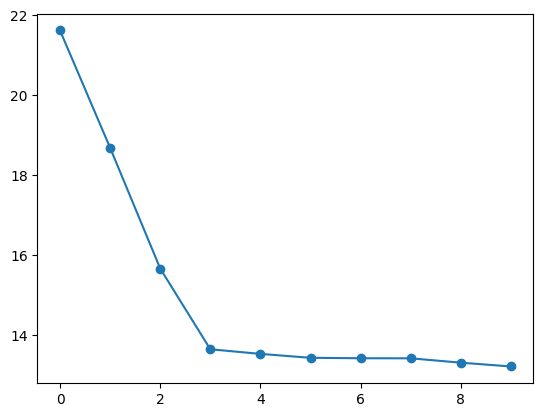

In [54]:
plt.plot(train_losses, "-o")
plt.show()

In [63]:
acc = accuracy_score(Model, test_labels)
print("Accuracy of the mini network:", acc)

Accuracy of the mini network: 0.5


**Transfer Learning**

In [55]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer_for_bert = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [56]:
def bert_tokens_generator (question, passage, max_len =  794):
  input_ids = tokenizer_for_bert.encode ( question, passage,  max_length= max_len, truncation= True)   
  cls_index = input_ids.index(102)
  len_question = cls_index + 1    
  len_answer = len(input_ids)- len_question  
  segment_ids =  [0]*len_question + [1]*(len_answer)  
  
  tokens = tokenizer_for_bert.convert_ids_to_tokens(input_ids) 
  return tokens

In [57]:
def bert_ChatBot(question, passage, max_len =  512):
  input_ids = tokenizer_for_bert.encode ( question, passage,  max_length= max_len, truncation= True)   
  cls_index = input_ids.index(102)
  len_question = cls_index + 1    
  len_answer = len(input_ids)- len_question  
  segment_ids =  [0]*len_question + [1]*(len_answer)  
  
  tokens = tokenizer_for_bert.convert_ids_to_tokens(input_ids) 
    
  start_token_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]) )[0]
  end_token_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]) )[1]

  start_token_scores = start_token_scores.detach().numpy().flatten()
  end_token_scores = end_token_scores.detach().numpy().flatten()
    
  answer_start_index = np.argmax(start_token_scores)
  answer_end_index = np.argmax(end_token_scores)

  start_token_score = np.round(start_token_scores[answer_start_index], 2)
  end_token_score = np.round(end_token_scores[answer_end_index], 2)
    
  answer = tokens[answer_start_index] 
  for i in range(answer_start_index + 1, answer_end_index + 1):
    if tokens[i][0:2] == '##': 
      answer += tokens[i][2:] 
    else:
      answer += ' ' + tokens[i]  
  if (answer_start_index == 0) or (start_token_score < 0 ) or  (answer == '[SEP]') or ( answer_end_index <  answer_start_index):
        answer = "Sorry!, I could not find  an answer in the passage."
    
  return (answer_start_index, answer_end_index, start_token_score, end_token_score,  answer)

In [22]:
multi='''Hi I'm ChatBot I'm Here to answer your Questions 
Enter your question for me (Enter quit to exit):  What is the primary objective of the Creative Consilience of Computing and the Arts (C2) initiative at Yale

ChatBot Answer:   Interdisciplinary collaboration. 

Enter your question for me (Enter quit to exit): What skills does C2 aim to develop for computer science students?

ChatBot Answer:  identifying diverse viewpoints

Enter your question for me (Enter quit to exit): How is information technology represented for arts students in C2?

ChatBot Answer:  as software tools 

Enter your question for me (Enter quit to exit): Did India win worldcup in 2023?

ChatBot Answer:  Sorry!, I could not find  an answer in the passage.

Enter your question for me (Enter quit to exit): quit
Thanks for chatting with me. See you soon with more Questions!!!'''
print(multi)

Hi I'm ChatBot I'm Here to answer your Questions 
Enter your question for me (Enter quit to exit):  What is the primary objective of the Creative Consilience of Computing and the Arts (C2) initiative at Yale

ChatBot Answer:   Interdisciplinary collaboration. 

Enter your question for me (Enter quit to exit): What skills does C2 aim to develop for computer science students?

ChatBot Answer:  identifying diverse viewpoints

Enter your question for me (Enter quit to exit): How is information technology represented for arts students in C2?

ChatBot Answer:  as software tools 

Enter your question for me (Enter quit to exit): Did India win worldcup in 2023?

ChatBot Answer:  Sorry!, I could not find  an answer in the passage.

Enter your question for me (Enter quit to exit): quit
Thanks for chatting with me. See you soon with more Questions!!!


In [62]:
count = 0
for i in answers:
  if i == "Sorry!, I could not find  an answer in the passage.":
    count = count+1
print("Accuracy Of the ChatBot:", 1-(count/len(answers)))

Accuracy Of the ChatBot: 0.75
